<img src="https://www.scienze.unimib.it/sites/sc02/files/scientifica_logo_scuola.png" align="left" width="150px" height="160px">

<h1><b>Task 2</b>: Image Segmentation on Echocardiogram Frames</h1>
<h4>Digital Signal and Image Management Project</h4>


In [1]:
TRAIN = False
GDRIVE = False

# Setup

In [2]:
%%capture
! pip install torchinfo
! pip install opencv-python

In [3]:
import os
import glob
import pathlib
import zipfile
import shutil
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import colors
import pickle
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    DATA_DIR = os.path.join(*[os.getcwd(), "drive", "MyDrive", "DSIM", "Segmentation"])
    GDRIVE = True
except Exception:
    DATA_DIR = os.getcwd()

print(f"Data is located at --> {DATA_DIR}")

Mounted at /content/drive
Data is located at --> /content/drive/MyDrive/DSIM/Segmentation


# UNET Model

In [5]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

In [6]:
class UNET(nn.Module):
  def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Down part of UNET
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    # Up part of UNET
    for feature in reversed(features):
      self.ups.append(
        nn.ConvTranspose2d(
          feature*2, feature, kernel_size=2, stride=2,
        )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x) # red arrow goes to the next (down) block

    x = self.bottleneck(x) # lowest part
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2): # index 0 and 2
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
          x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

In [7]:
batch_size = 5
x = torch.randn((batch_size, 1, 112, 112))
model = UNET(in_channels=1, out_channels=1)
preds = model(x)
assert preds.shape == x.shape
summary(
  model=model,
  input_size=x.size(),
  col_names=["input_size", "output_size", "num_params", "trainable"],
  col_width=20,
  row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNET (UNET)                              [5, 1, 112, 112]     [5, 1, 112, 112]     --                   True
├─ModuleList (downs)                     --                   --                   (recursive)          True
│    └─DoubleConv (0)                    [5, 1, 112, 112]     [5, 64, 112, 112]    --                   True
│    │    └─Sequential (conv)            [5, 1, 112, 112]     [5, 64, 112, 112]    37,696               True
├─MaxPool2d (pool)                       [5, 64, 112, 112]    [5, 64, 56, 56]      --                   --
├─ModuleList (downs)                     --                   --                   (recursive)          True
│    └─DoubleConv (1)                    [5, 64, 56, 56]      [5, 128, 56, 56]     --                   True
│    │    └─Sequential (conv)            [5, 64, 56, 56]      [5, 128, 56, 56]     221,696              True
├─MaxPool2d (poo

# Dataset and Dataloader

In [8]:
if GDRIVE:
    FILE_DIR = os.path.join(DATA_DIR, "echonet-processed.zip")
    shutil.copyfile(FILE_DIR, "echonet-processed.zip")

    with zipfile.ZipFile("echonet-processed.zip", 'r') as file:
      file.extractall(os.getcwd())

    DATA_DIR = os.path.join(*[os.getcwd(), "echonet-processed"])
    WORK_DIR = os.path.join(*[os.getcwd(), "drive", "MyDrive", "DSIM", "Segmentation"])

else:
  DATA_DIR = os.path.join(*[os.getcwd(), "echonet-processed"])
  WORK_DIR = os.getcwd()

In [9]:
class EchoNetDataset(Dataset):
  def __init__(self, data_dir, split="train", use_few_data=False, show_item_name=False):
    self.data_dir = data_dir
    self.split = split
    os.chdir(os.path.join(*[data_dir, split, "image"]))
    self.data = list(glob.glob('*.png'))
    self.show_item_name = show_item_name

    if use_few_data:
        if split == "train":
            self.data = random.sample(self.data, 50)
        elif split == "test":
            self.data = ["0X100CF05D141FF143_132.png"]
        else:
            self.data = random.sample(self.data, 10)

  def transform(self, image, mask):

    # Transform to tensor
    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)

    # Random horizontal flipping
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    # Random vertical flipping
    if random.random() > 0.5:
        image = TF.vflip(image)
        mask = TF.vflip(mask)

    # Random rotation
    if random.random() > 0.5:
        image = TF.rotate(image, 20)
        mask = TF.rotate(mask,  20)

    image = TF.normalize(image, 0, 1)

    return image, mask

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    if self.show_item_name:
      print(self.data[index])

    img_path = os.path.join(*[self.data_dir, self.split, "image", self.data[index]])
    mask_path = os.path.join(*[self.data_dir, self.split, "mask", self.data[index]])
    image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

    if self.split == "train":
        image, mask = self.transform(image, mask)
    else:
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

    return image, mask

Size -------------------------------------------------------------
img size --> [b_size, channels, h, w] --> [10, 1, 112, 112]
msk size --> [b_size, channels, h, w] --> [10, 1, 112, 112] 

Values -----------------------------------------------------------
img --> min: 0.007843137718737125, max: 1.0, q50: 0.03529411926865578
msk --> min: 0.0, max: 1.0, q50: 0.0 

Example ----------------------------------------------------------


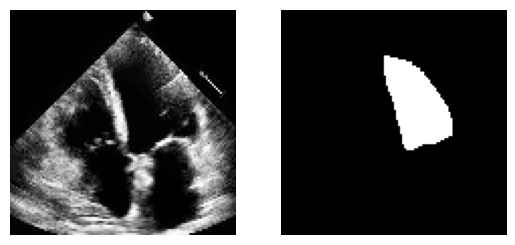

In [10]:
# Example
example_ds = EchoNetDataset(data_dir=DATA_DIR, split="val", use_few_data=True)
loader_example = DataLoader(example_ds, batch_size=10, shuffle=True)
img, msk = next(iter(loader_example))

print("Size -------------------------------------------------------------")
print(f"img size --> [b_size, channels, h, w] --> {list(img.size())}")
print(f"msk size --> [b_size, channels, h, w] --> {list(msk.size())} \n")

print("Values -----------------------------------------------------------")
print(f"img --> min: {img.min()}, max: {img.max()}, q50: {img.median()}")
print(f"msk --> min: {msk.min()}, max: {msk.max()}, q50: {msk.median()} \n")

print("Example ----------------------------------------------------------")
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(img[0].squeeze().numpy(), cmap="gray")
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(msk[0].squeeze().numpy(), cmap="gray")
plt.show()

# Train

## Training Functions

In [11]:
class EarlyStopping():

    def __init__(self, patience=20, mode='min'):
        if mode not in ['min', 'max']:
            raise ValueError("Early-stopping mode not supported")
        self.patience = patience
        self.mode = mode
        self.counter = 0
        self.best_val = None

    def __call__(self, val):
        val = float(val)

        if self.best_val is None:
            self.best_val = val
        elif self.mode == 'min' and val < self.best_val:
            self.best_val = val
            self.counter = 0
        elif self.mode == 'max' and val > self.best_val:
            self.best_val = val
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early Stopping!")
                return True

        return False

In [12]:
def get_dice_score(outputs, targets):
  dice_score = (2 * (outputs * targets).sum() /
                     (outputs + targets).sum() + 1e-8)
  return dice_score

def get_IoU_score(outputs, targets):
  intersection = torch.logical_and(outputs, targets).sum()
  union = torch.logical_or(outputs, targets).sum()
  IoU_score = (intersection + 1e-8) / (union + 1e-8)
  return IoU_score

def get_precision(outputs, targets):
  true_positives = (outputs * targets).sum()
  predicted_positives = outputs.sum()
  precision = true_positives / (predicted_positives + 1e-8)
  return precision

def get_recall(outputs, targets):
  true_positives = (outputs * targets).sum()
  actual_positives = targets.sum()
  recall = true_positives / (actual_positives + 1e-8)
  return recall

def check_metrics(loader, model):
  dice_score = 0
  IoU_score = 0
  precision = 0
  recall = 0
  pixel_score = 0
  num_correct = 0
  num_pixels = 0

  model.eval()
  with torch.inference_mode():
    for x, y in loader:
      x = x.to(DEVICE)
      y = y.to(DEVICE)
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += get_dice_score(preds, y)
      IoU_score += get_IoU_score(preds, y)
      precision += get_precision(preds, y)
      recall += get_recall(preds, y)
  model.train()

  px_acc = num_correct/num_pixels*100
  iou_score = IoU_score/len(loader)
  dice_score = dice_score/len(loader)
  precision = precision/len(loader)
  recall = recall/len(loader)

  print(f"Pixel Accuracy {px_acc:.2f} \t" \
        f"IoU score: {iou_score:.2f} \t" \
        f"Dice score: {dice_score:.2f} \t" \
        f"Precison: {precision:.2f} \t" \
        f"Recall: {recall:.2f}")

  return px_acc.cpu(), iou_score.cpu(), dice_score.cpu(), precision.cpu(), recall.cpu()

In [13]:
def train_step(model, data_loader, loss_fn, optimizer, scheduler=None):

  train_loss = 0

  loop = tqdm(data_loader)

  for batch, (X, y) in enumerate(loop):

    # Send data to GPU
    X, y = X.to(DEVICE), y.type(torch.float32).to(DEVICE)

    # Forward Pass
    y_pred = model(X)

    # Calculate Loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer reset step
    optimizer.zero_grad()

    # Loss Backpropagation
    loss.backward(retain_graph=True)

    # Optimizer step
    optimizer.step()

    # Clean Cache
    torch.cuda.empty_cache()

    # Keep track of train loss
    loop.set_postfix(loss=loss.item())

  # Scheduler step
  if scheduler is not None:
    scheduler.step()

  with torch.inference_mode():
      train_loss /= len(data_loader)

  return train_loss

In [14]:
def val_step(model, data_loader, loss_fn):
  val_loss = 0

  model.eval()
  with torch.inference_mode():

    for batch, (X, y) in enumerate(data_loader):

      # Send data to GPU
      X, y = X.to(DEVICE), y.type(torch.float32).to(DEVICE)

      # Forward pass
      test_pred = model(X)
      # test_pred = test_pred.squeeze()

      # Calculate loss
      loss = loss_fn(test_pred, y)
      val_loss += loss.item()

      # Clean Cache
      torch.cuda.empty_cache()

    val_loss /= len(data_loader)

  return val_loss

In [15]:
def train(model, train_loader, val_loader, optimizer, loss_fn,
          epochs, early_stop, scheduler=None):

  results = {
      "train_loss": [], "val_loss": [],
      "train_px_acc": [], "val_px_acc": [],
      "train_iou_score": [], "val_iou_score": [],
      "train_dice_score": [], "val_dice_score": [],
      "train_precision": [], "val_precision": [],
      "train_recall": [], "val_recall": []
  }

  for epoch in range(epochs):
    print(f"Epoch {epoch}")

    train_loss = train_step(
        model=model,
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
    )

    print("Train metrics")
    px_acc, iou_score, dice_score, precision, recall = check_metrics(train_loader, model)

    results["train_loss"].append(train_loss)
    results["train_px_acc"].append(px_acc)
    results["train_iou_score"].append(iou_score)
    results["train_dice_score"].append(dice_score)
    results["train_precision"].append(precision)
    results["train_recall"].append(recall)

    val_loss = val_step(
        model=model,
        data_loader=val_loader,
        loss_fn=loss_fn
    )

    print("Val metrics")
    px_acc, iou_score, dice_score, precision, recall = check_metrics(val_loader, model)

    results["val_loss"].append(val_loss)
    results["val_px_acc"].append(px_acc)
    results["val_iou_score"].append(iou_score)
    results["val_dice_score"].append(dice_score)
    results["val_precision"].append(precision)
    results["val_recall"].append(recall)

    # early stopping
    if early_stop(val_loss):
        print(f"Stopped at epoch {epoch + 1} because of early stopping")
        break

  return results

In [16]:
def train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs):

    model = UNET(in_channels=1, out_channels=1, features=features).to(DEVICE)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.1)
    earlystop = EarlyStopping(patience=3, mode='min')
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

    os.makedirs(os.path.join(*[WORK_DIR, "models", model_name, "predictions"]), exist_ok=True)
    model_path = os.path.join(*[WORK_DIR, "models", model_name, f"model.pt"])
    history_path = os.path.join(*[WORK_DIR, "models", model_name, f"history.pkl"])
    if TRAIN:
      history = train(model, train_loader, val_loader, optimizer, loss_fn,
                      num_epochs, earlystop, scheduler=scheduler)
      torch.save(model.state_dict(), model_path)
      pickle.dump(history, open(history_path, "wb"))
      save_predictions_as_imgs(val_loader, model, os.path.join(*[WORK_DIR, "models", model_name, "predictions"]))
    else:
      model.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
      history = pickle.load(open(history_path, "rb"))

    return model, history

## Show Results Functions

In [17]:
def save_predictions_as_imgs(loader, model, folder, model_name=None):
  plt.ioff()
  model.eval()
  cmap_red = colors.ListedColormap([(0,0,0,0), 'red'])
  cmap_white = colors.ListedColormap([(0,0,0,0), 'white'])
  for idx, (x, y) in enumerate(loader):
    x = x.to(device=DEVICE)
    with torch.inference_mode():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.axis("off")
    plt.title("Frame")
    plt.imshow(x[0].squeeze().cpu().numpy(), cmap="gray", interpolation='none')

    plt.subplot(1,3,2)
    plt.axis("off")
    plt.title("Ground Truth")
    plt.imshow(x[0].squeeze().cpu().numpy(), cmap='gray', interpolation='none')
    plt.imshow(y[0].squeeze().cpu().numpy(), cmap=cmap_white)

    plt.subplot(1,3,3)
    plt.axis("off")
    plt.title("Prediction")
    plt.imshow(x[0].squeeze().cpu().numpy(), 'gray', interpolation='none')
    plt.imshow(preds[0].squeeze().cpu().numpy(), cmap=cmap_red)

    if model_name is not None:
        plt.savefig(os.path.join(folder, f"{model_name}.png"))
        plt.close()
        break
    else:
        plt.savefig(os.path.join(folder, f"pred_{idx}.png"))

    plt.close()

  model.train()
  plt.ion()

In [18]:
def show_loss(hist):

    last_idx = len(hist.get("train_px_acc")) - 1
    print(f'Pixel Ac--> \t T: {hist.get("train_px_acc")[last_idx]/100:.4f} \t V: {hist.get("val_px_acc")[last_idx]/100:.4f} \n' \
        f'IoU score --> \t T: {hist.get("train_iou_score")[last_idx]:.4f} \t V: {hist.get("val_iou_score")[last_idx]:.4f} \n' \
        f'Dice score --> \t T: {hist.get("train_dice_score")[last_idx]:.4f} \t V: {hist.get("val_dice_score")[last_idx]:.4f} \n' \
        f'Precison --> \t T: {hist.get("train_precision")[last_idx]:.4f} \t V: {hist.get("val_precision")[last_idx]:.4f} \n' \
        f'Recall --> \t T: {hist.get("train_recall")[last_idx]:.4f} \t V: {hist.get("val_recall")[last_idx]:.4f}')

    plt.figure(figsize=(15, 4))

    plt.subplot(1,3,1)
    plt.plot(history.get("train_loss"), label='Train')
    plt.plot(history.get("val_loss"), label='Val')
    plt.legend()
    plt.title("Loss")

    plt.subplot(1,3,2)
    plt.plot(history.get("train_dice_score"), label='Train')
    plt.plot(history.get("val_dice_score"), label='Val')
    plt.legend()
    plt.title("Dice Score")

    plt.subplot(1,3,3)
    plt.plot(history.get("train_iou_score"), label='Train')
    plt.plot(history.get("val_iou_score"), label='Val')
    plt.legend()
    plt.title("Intersection Over Union")

    plt.show()

In [19]:
def make_prediction(sample, model):
  model.eval()
  cmap_red = colors.ListedColormap([(0,0,0,0), 'red'])
  cmap_white = colors.ListedColormap([(0,0,0,0), 'white'])

  x = sample[0].to(device=DEVICE)
  with torch.inference_mode():
    preds = torch.sigmoid(model(x))
    preds = (preds > 0.5).float()
  return preds

## Using all Data

In [20]:
train_ds = EchoNetDataset(data_dir=DATA_DIR)
val_ds = EchoNetDataset(data_dir=DATA_DIR, split="val")

### UNET Base [64, 128, 256, 512]

Pixel Ac--> 	 T: 0.9911 	 V: 0.9905 
IoU score --> 	 T: 0.8617 	 V: 0.8538 
Dice score --> 	 T: 0.9257 	 V: 0.9211 
Precison --> 	 T: 0.9286 	 V: 0.9233 
Recall --> 	 T: 0.9229 	 V: 0.9191


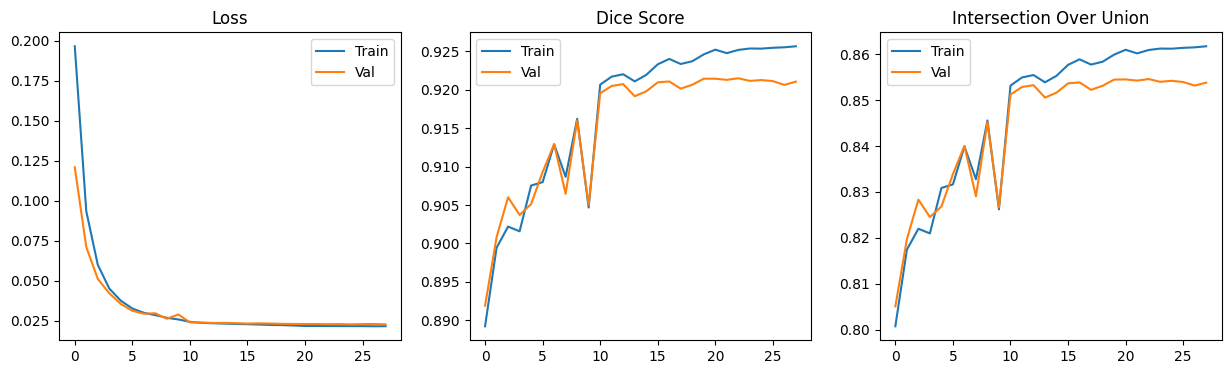

In [21]:
TRAIN = False

lr = 1e-4
batch_size = 32
num_epochs = 50

model_name = "base"
features = [64, 128, 256, 512]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

### UNET Exp1 [32, 64, 128, 256]

Pixel Ac--> 	 T: 0.9910 	 V: 0.9905 
IoU score --> 	 T: 0.8597 	 V: 0.8532 
Dice score --> 	 T: 0.9245 	 V: 0.9207 
Precison --> 	 T: 0.9271 	 V: 0.9228 
Recall --> 	 T: 0.9221 	 V: 0.9188


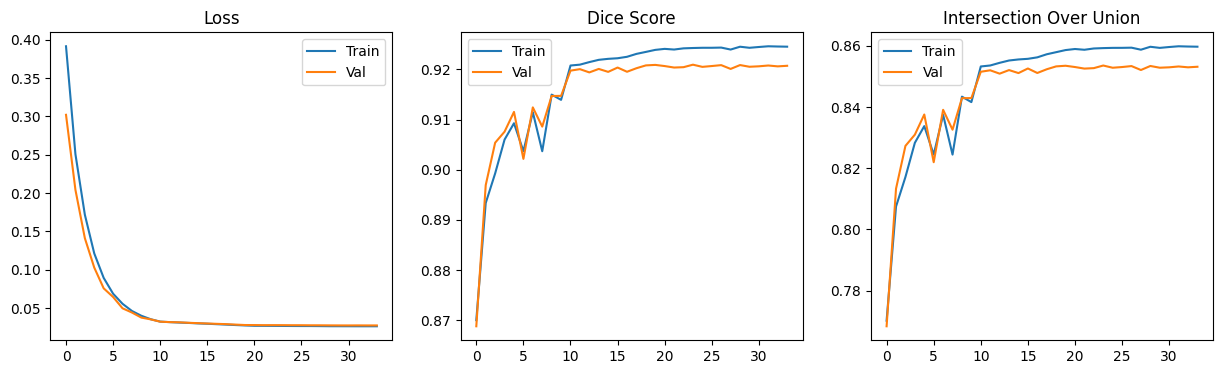

In [22]:
TRAIN = False

lr = 1e-4
batch_size = 32
num_epochs = 50

model_name = "exp1"
features = [32, 64, 128, 256]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

### UNET Exp2 [16, 32, 64, 128]

Pixel Ac--> 	 T: 0.9905 	 V: 0.9901 
IoU score --> 	 T: 0.8522 	 V: 0.8482 
Dice score --> 	 T: 0.9201 	 V: 0.9178 
Precison --> 	 T: 0.9254 	 V: 0.9221 
Recall --> 	 T: 0.9151 	 V: 0.9137


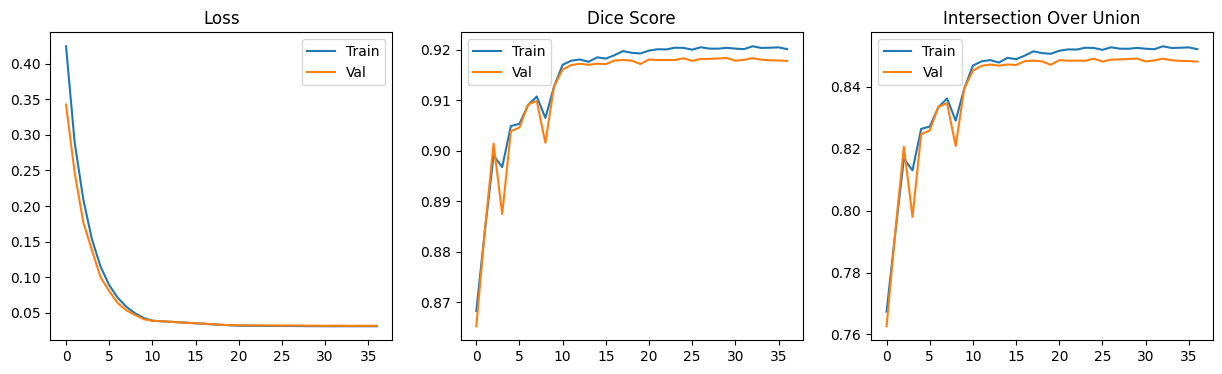

In [23]:
TRAIN = False

lr = 1e-4
batch_size = 32
num_epochs = 50

model_name = "exp2"
features = [16, 32, 64, 128]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

### UNET Exp3 [8, 16, 32, 64]

Pixel Ac--> 	 T: 0.9896 	 V: 0.9893 
IoU score --> 	 T: 0.8392 	 V: 0.8361 
Dice score --> 	 T: 0.9125 	 V: 0.9107 
Precison --> 	 T: 0.9233 	 V: 0.9215 
Recall --> 	 T: 0.9022 	 V: 0.9003


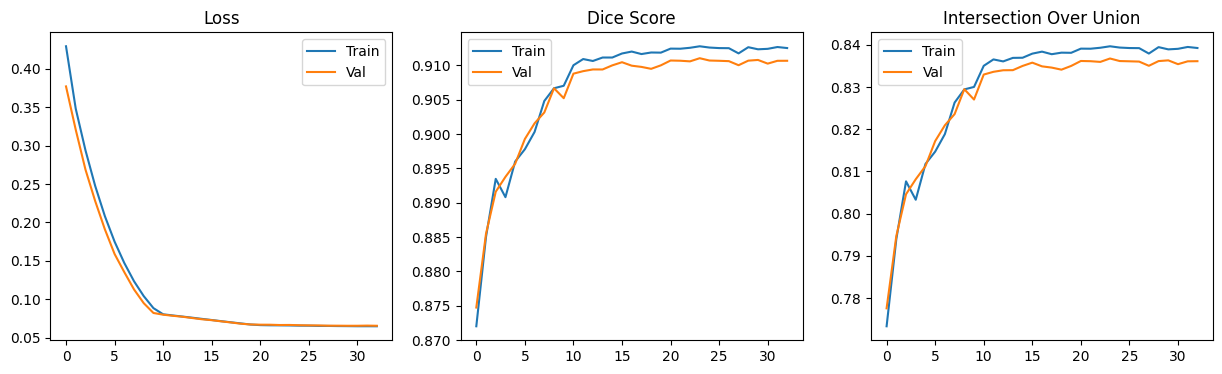

In [24]:
TRAIN = False

lr = 1e-4
batch_size = 32
num_epochs = 50

model_name = "exp3"
features = [8, 16, 32, 64]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

### UNET Exp4 [4, 8, 16, 32]

Pixel Ac--> 	 T: 0.9878 	 V: 0.9878 
IoU score --> 	 T: 0.8127 	 V: 0.8130 
Dice score --> 	 T: 0.8965 	 V: 0.8967 
Precison --> 	 T: 0.9137 	 V: 0.9150 
Recall --> 	 T: 0.8803 	 V: 0.8795


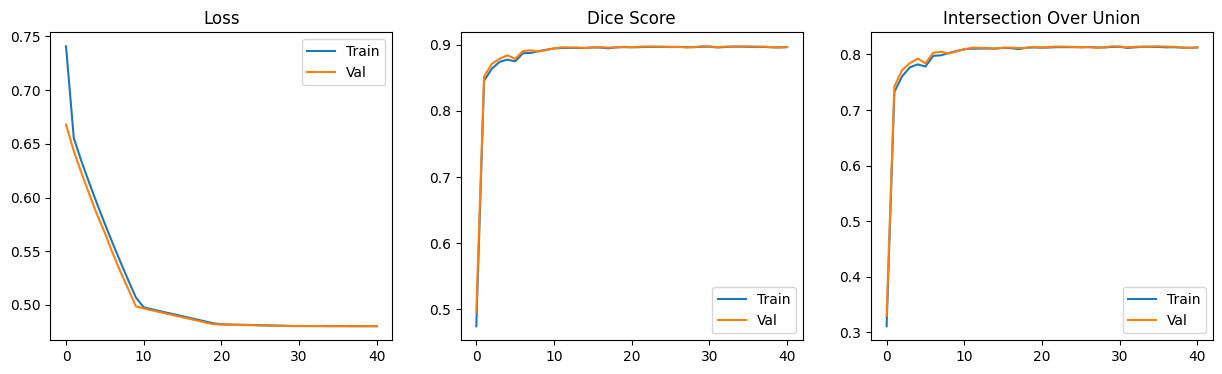

In [25]:
TRAIN = False

lr = 1e-4
batch_size = 32
num_epochs = 50

model_name = "exp4"
features = [4, 8, 16, 32]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

### UNET Exp5 [2, 4, 8, 16]

Pixel Ac--> 	 T: 0.9861 	 V: 0.9864 
IoU score --> 	 T: 0.7912 	 V: 0.7956 
Dice score --> 	 T: 0.8833 	 V: 0.8860 
Precison --> 	 T: 0.8889 	 V: 0.8929 
Recall --> 	 T: 0.8781 	 V: 0.8796


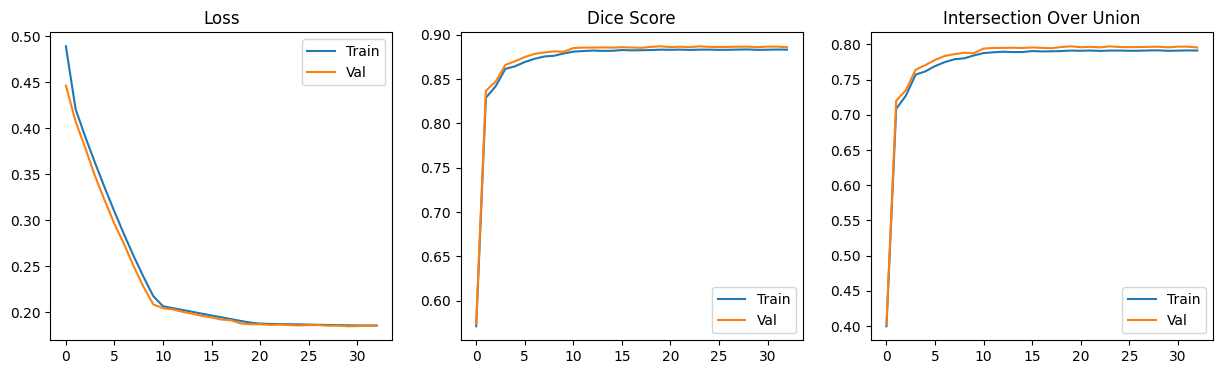

In [26]:
TRAIN = False

lr = 1e-4
batch_size = 32
num_epochs = 50

model_name = "exp5"
features = [2, 4, 8, 16]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

## Using few Data

In [27]:
train_ds = EchoNetDataset(data_dir=DATA_DIR, use_few_data=True)
val_ds = EchoNetDataset(data_dir=DATA_DIR, split="val", use_few_data=True)

### UNET Base [64, 128, 256, 512]

Pixel Ac--> 	 T: 0.9851 	 V: 0.9797 
IoU score --> 	 T: 0.7613 	 V: 0.7105 
Dice score --> 	 T: 0.8636 	 V: 0.8295 
Precison --> 	 T: 0.8783 	 V: 0.9406 
Recall --> 	 T: 0.8503 	 V: 0.7430


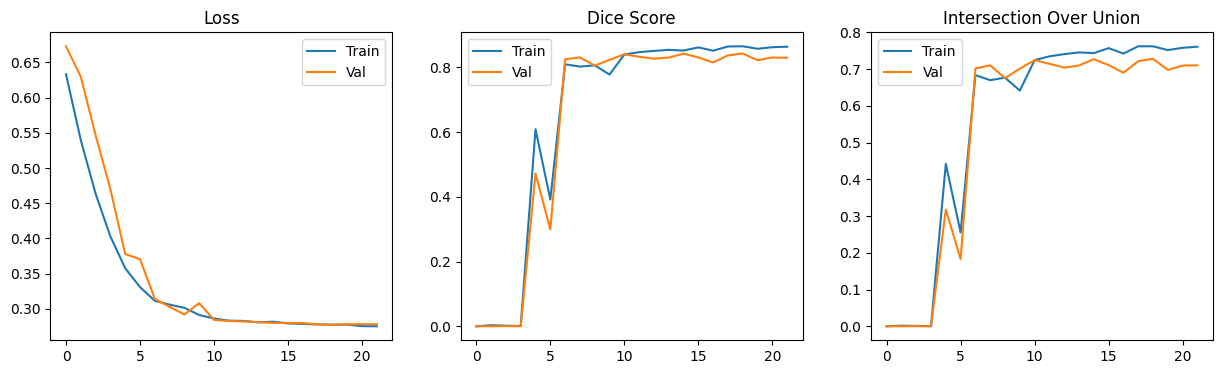

In [28]:
TRAIN = False

lr = 1e-4
batch_size = 5
num_epochs = 50

model_name = "dbase"
features = [64, 128, 256, 512]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

### UNET Exp1 [32, 64, 128, 256]

Pixel Ac--> 	 T: 0.9846 	 V: 0.9778 
IoU score --> 	 T: 0.7808 	 V: 0.6109 
Dice score --> 	 T: 0.8765 	 V: 0.7582 
Precison --> 	 T: 0.8578 	 V: 0.7341 
Recall --> 	 T: 0.9007 	 V: 0.8058


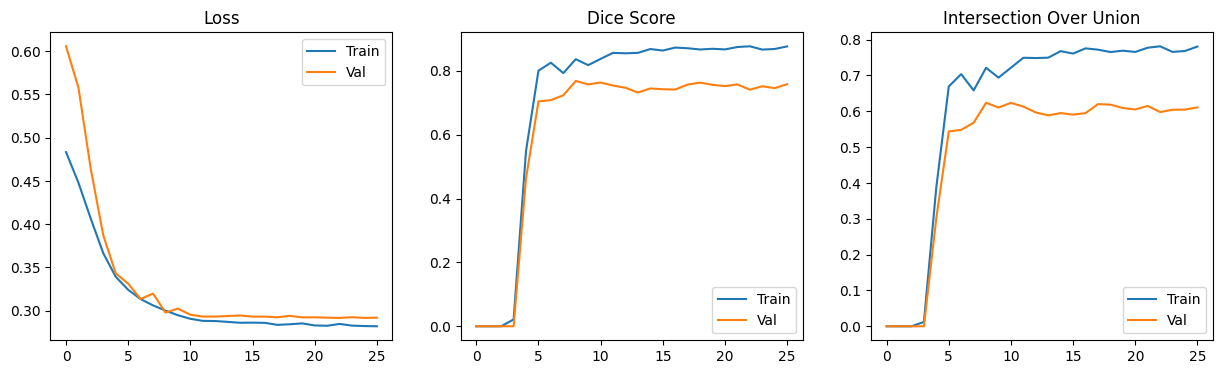

In [29]:
TRAIN = False

lr = 1e-4
batch_size = 5
num_epochs = 50

model_name = "dexp1"
features = [32, 64, 128, 256]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

### UNET Exp2 [16, 32, 64, 128]

Pixel Ac--> 	 T: 0.9768 	 V: 0.9722 
IoU score --> 	 T: 0.7031 	 V: 0.5757 
Dice score --> 	 T: 0.8245 	 V: 0.7300 
Precison --> 	 T: 0.7557 	 V: 0.6424 
Recall --> 	 T: 0.9090 	 V: 0.8464


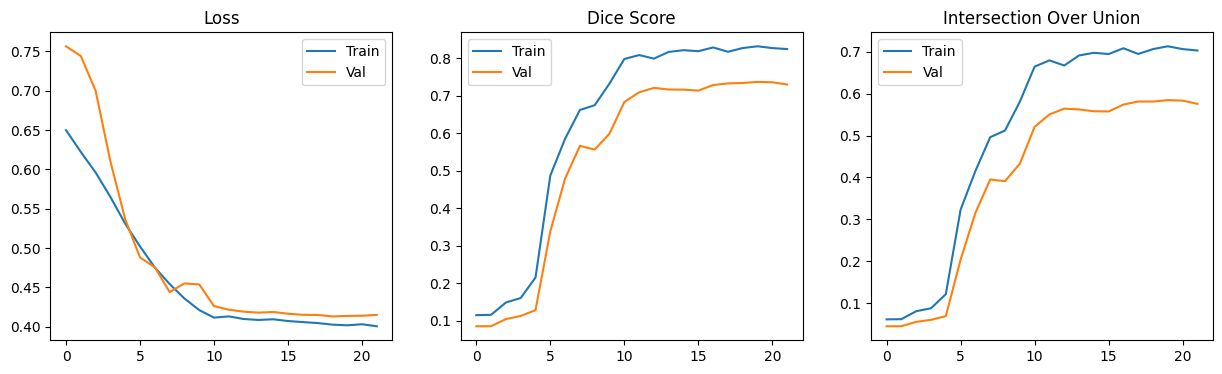

In [30]:
TRAIN = False

lr = 1e-4
batch_size = 5
num_epochs = 50

model_name = "dexp2"
features = [16, 32, 64, 128]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

### UNET Exp3 [8, 16, 32, 64]

Pixel Ac--> 	 T: 0.9735 	 V: 0.9677 
IoU score --> 	 T: 0.6440 	 V: 0.5993 
Dice score --> 	 T: 0.7823 	 V: 0.7491 
Precison --> 	 T: 0.7353 	 V: 0.8091 
Recall --> 	 T: 0.8371 	 V: 0.7063


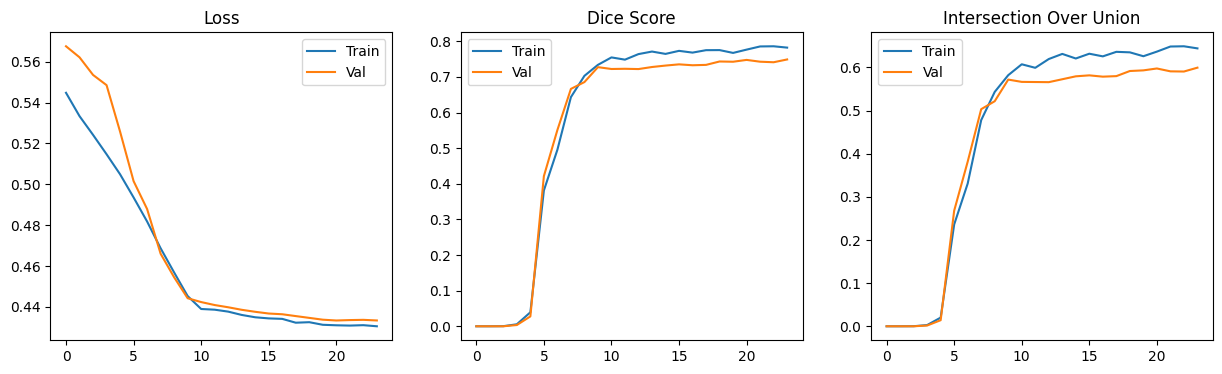

In [31]:
TRAIN = False

lr = 1e-4
batch_size = 5
num_epochs = 50

model_name = "dexp3"
features = [8, 16, 32, 64]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

### UNET Exp4 [4, 8, 16, 32]

Pixel Ac--> 	 T: 0.9309 	 V: 0.9229 
IoU score --> 	 T: 0.0508 	 V: 0.0819 
Dice score --> 	 T: 0.0964 	 V: 0.1514 
Precison --> 	 T: 0.1986 	 V: 0.3189 
Recall --> 	 T: 0.0639 	 V: 0.1006


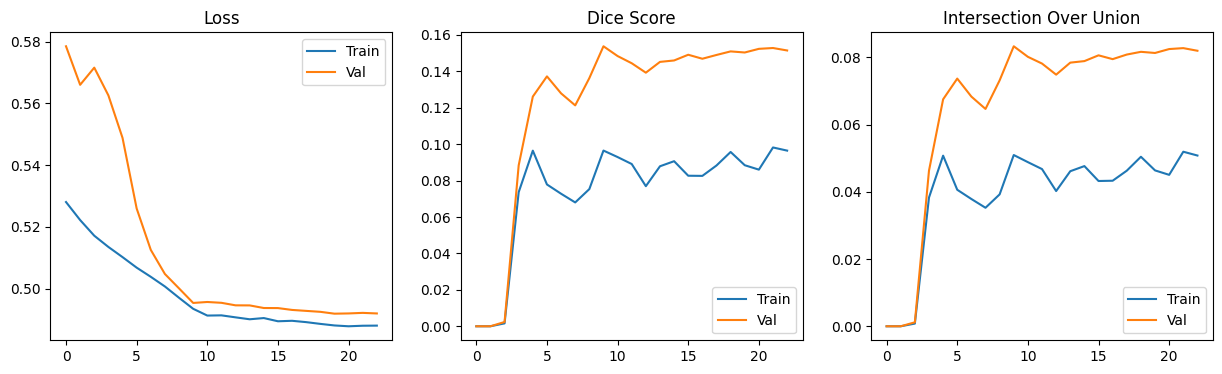

In [32]:
TRAIN = False

lr = 1e-4
batch_size = 5
num_epochs = 50

model_name = "dexp4"
features = [4, 8, 16, 32]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

### UNET Exp5 [2, 4, 8, 16]

Pixel Ac--> 	 T: 0.9423 	 V: 0.9312 
IoU score --> 	 T: 0.0000 	 V: 0.0000 
Dice score --> 	 T: 0.0000 	 V: 0.0000 
Precison --> 	 T: 0.0000 	 V: 0.0000 
Recall --> 	 T: 0.0000 	 V: 0.0000


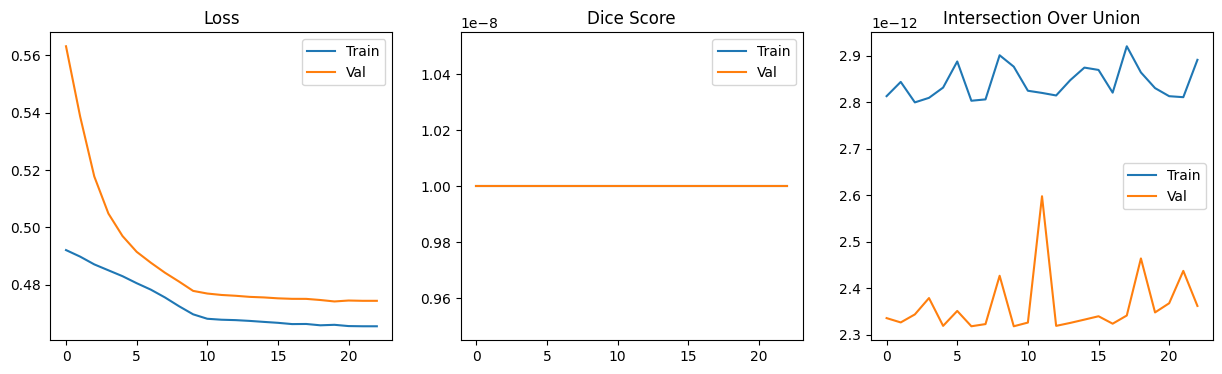

In [33]:
TRAIN = False

lr = 1e-4
batch_size = 5
num_epochs = 50

model_name = "dexp5"
features = [2, 4, 8, 16]
model, history = train_load_model(model_name, features, train_ds, val_ds, lr, batch_size, num_epochs)
show_loss(history)

# Comparison

In [34]:
test_ds = EchoNetDataset(data_dir=DATA_DIR, split="test", use_few_data=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
sample = next(iter(test_loader))

model_names = ["base", "exp1", "exp2", "exp3", "exp4", "exp5",
              "dbase", "dexp1", "dexp2", "dexp3", "dexp4", "dexp5",]
features = [[64, 128, 256, 512], [32, 64, 128, 256], [16, 32, 64, 128], [8, 16, 32, 64], [4, 8, 16, 32], [2, 4, 8, 16],
           [64, 128, 256, 512], [32, 64, 128, 256], [16, 32, 64, 128], [8, 16, 32, 64], [4, 8, 16, 32], [2, 4, 8, 16]]

for model_name, feats in zip(model_names, features):
    model = UNET(in_channels=1, out_channels=1, features=feats).to(DEVICE)

    model_path = os.path.join(*[WORK_DIR, "models", model_name, f"model.pt"])
    history_path = os.path.join(*[WORK_DIR, "models", model_name, f"history.pkl"])

    model.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
    history = pickle.load(open(history_path, "rb"))

    os.makedirs(os.path.join(*[WORK_DIR, "models", "comparison"]), exist_ok=True)
    save_predictions_as_imgs(test_loader, model, os.path.join(*[WORK_DIR, "models", "comparison"]), model_name=model_name)

# Demo

In [41]:
test_ds = EchoNetDataset(data_dir=DATA_DIR, split="test", show_item_name=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True)
sample = next(iter(test_loader))

0X5DFC0C66C150F577_87.png


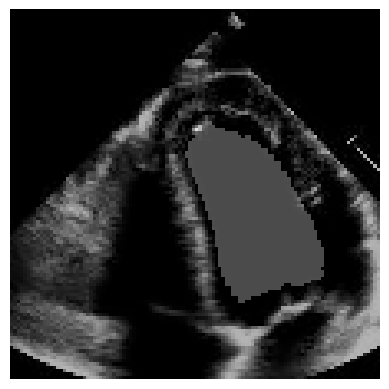

In [42]:
plt.imshow(sample[0].squeeze().cpu().numpy(), 'gray'); plt.axis("off")
plt.imshow(sample[1].squeeze().cpu().numpy(), 'gray', alpha=0.3); plt.axis("off")
plt.show()

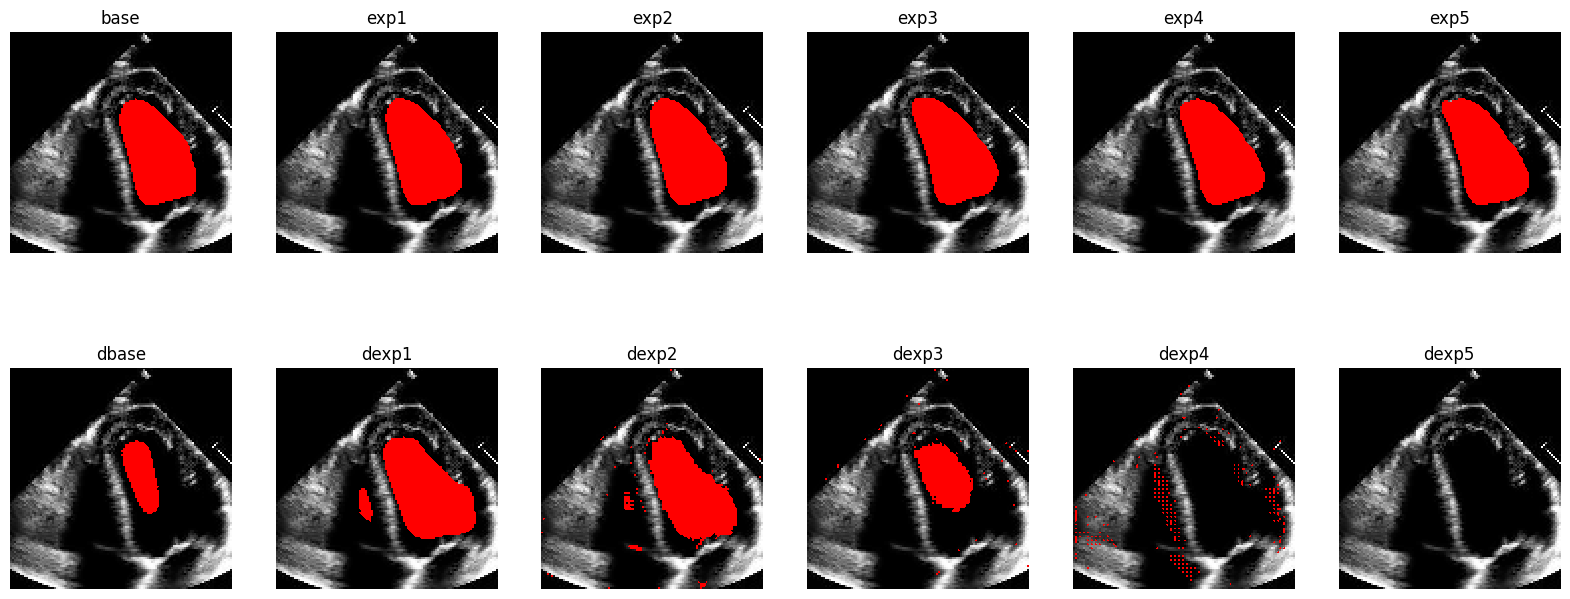

In [43]:
# For each model we save the predicted result
model_names = ["base", "exp1", "exp2", "exp3", "exp4", "exp5",
              "dbase", "dexp1", "dexp2", "dexp3", "dexp4", "dexp5",]
features = [[64, 128, 256, 512], [32, 64, 128, 256], [16, 32, 64, 128], [8, 16, 32, 64], [4, 8, 16, 32], [2, 4, 8, 16],
           [64, 128, 256, 512], [32, 64, 128, 256], [16, 32, 64, 128], [8, 16, 32, 64], [4, 8, 16, 32], [2, 4, 8, 16]]

predictions = []

for model_name, feats in zip(model_names, features):
  model = UNET(in_channels=1, out_channels=1, features=feats).to(DEVICE)

  model_path = os.path.join(*[WORK_DIR, "models", model_name, f"model.pt"])
  history_path = os.path.join(*[WORK_DIR, "models", model_name, f"history.pkl"])

  model.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
  history = pickle.load(open(history_path, "rb"))

  pred = make_prediction(sample, model)

  predictions.append(pred)

plt.figure(figsize=(20,8))
cmap_red = colors.ListedColormap([(0,0,0,0), 'red'])
for idx, (img, name) in enumerate(zip(predictions, model_names)):
  plt.subplot(2,6,idx+1)
  plt.axis("off")
  plt.title(name)
  plt.imshow(sample[0].squeeze().cpu().detach().numpy(), 'gray', interpolation='none')
  plt.imshow(img.squeeze().cpu().detach().numpy(), cmap=cmap_red)
plt.show()